# 📈 상관관계 및 리스크 패턴 분석

## 목표: 변수 간 관계를 심층 분석하고 다중공선성을 제거하여 모델 성능 최적화

이 노트북에서는:
- 선형/비선형 상관관계 분석
- 다중공선성 탐지 및 제거 (VIF)
- Feature Selection (Information Value)
- 파이프라인 시각화

In [31]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.cluster import hierarchy
from scipy.stats import spearmanr, kendalltau
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import networkx as nx

# 한글 폰트
import platform
if platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# 데이터 로딩
df = pd.read_csv('../data/features/domain_based_features.csv', encoding='utf-8-sig')
target_col = '모형개발용Performance(향후1년내부도여부)'

print(f"✅ 데이터 로딩: {df.shape}")

✅ 데이터 로딩: (50105, 66)


## 1. 선형 상관관계 분석

In [32]:
# 수치형 특성만 선택
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
if target_col in numeric_features:
    numeric_features.remove(target_col)

# 결측치 처리
df_numeric = df[numeric_features].fillna(df[numeric_features].median())
df_numeric = df_numeric.replace([np.inf, -np.inf], 0)

# Pearson 상관계수 계산
corr_matrix = df_numeric.corr()

print(f"✅ {len(numeric_features)}개 수치형 특성의 상관관계 분석 완료")

# 고상관 변수 쌍 찾기 (|r| > 0.8)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((
                corr_matrix.columns[i],
                corr_matrix.columns[j],
                corr_matrix.iloc[i, j]
            ))

print(f"\n⚠️ 고상관(|r| > 0.8) 변수 쌍: {len(high_corr_pairs)}개")
if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs, columns=['변수1', '변수2', '상관계수'])
    print(high_corr_df.head(10))

✅ 64개 수치형 특성의 상관관계 분석 완료

⚠️ 고상관(|r| > 0.8) 변수 쌍: 19개
         변수1          변수2      상관계수
0     즉각지급능력      재무건전성지수  0.997321
1     운전자본비율    유동성스트레스지수 -1.000000
2  운전자본_대_자산      유동성압박지수 -0.891999
3      자본잠식도     지급불능위험지수  1.000000
4      자본잠식도    종합부도위험스코어  0.991517
5     재무레버리지       부채레버리지  0.961152
6     매출채권비율  M_Score_한국형  1.000000
7     매출채권비율      매출채권집중도  1.000000
8     매출채권비율       거래처리스크  1.000000
9     영업레버리지         판관비율 -0.853863


In [33]:
# 상관관계 히트맵 (상위 30개 특성)
# 타겟과의 상관관계가 높은 상위 30개 선택
if target_col in df.columns:
    target_corr = df_numeric.corrwith(df[target_col].fillna(0)).abs().sort_values(ascending=False)
    top_features = target_corr.head(30).index.tolist()
    
    fig = go.Figure(data=go.Heatmap(
        z=corr_matrix.loc[top_features, top_features].values,
        x=top_features,
        y=top_features,
        colorscale='RdBu_r',
        zmid=0,
        text=corr_matrix.loc[top_features, top_features].values,
        texttemplate='%{text:.2f}',
        textfont={"size": 8}
    ))
    
    fig.update_layout(
        title='상관관계 히트맵 (타겟 예측력 상위 30개 특성)',
        xaxis={'tickangle': 45},
        height=800,
        width=900
    )
    fig.show()

## 2. 계층적 클러스터링으로 변수 그룹화

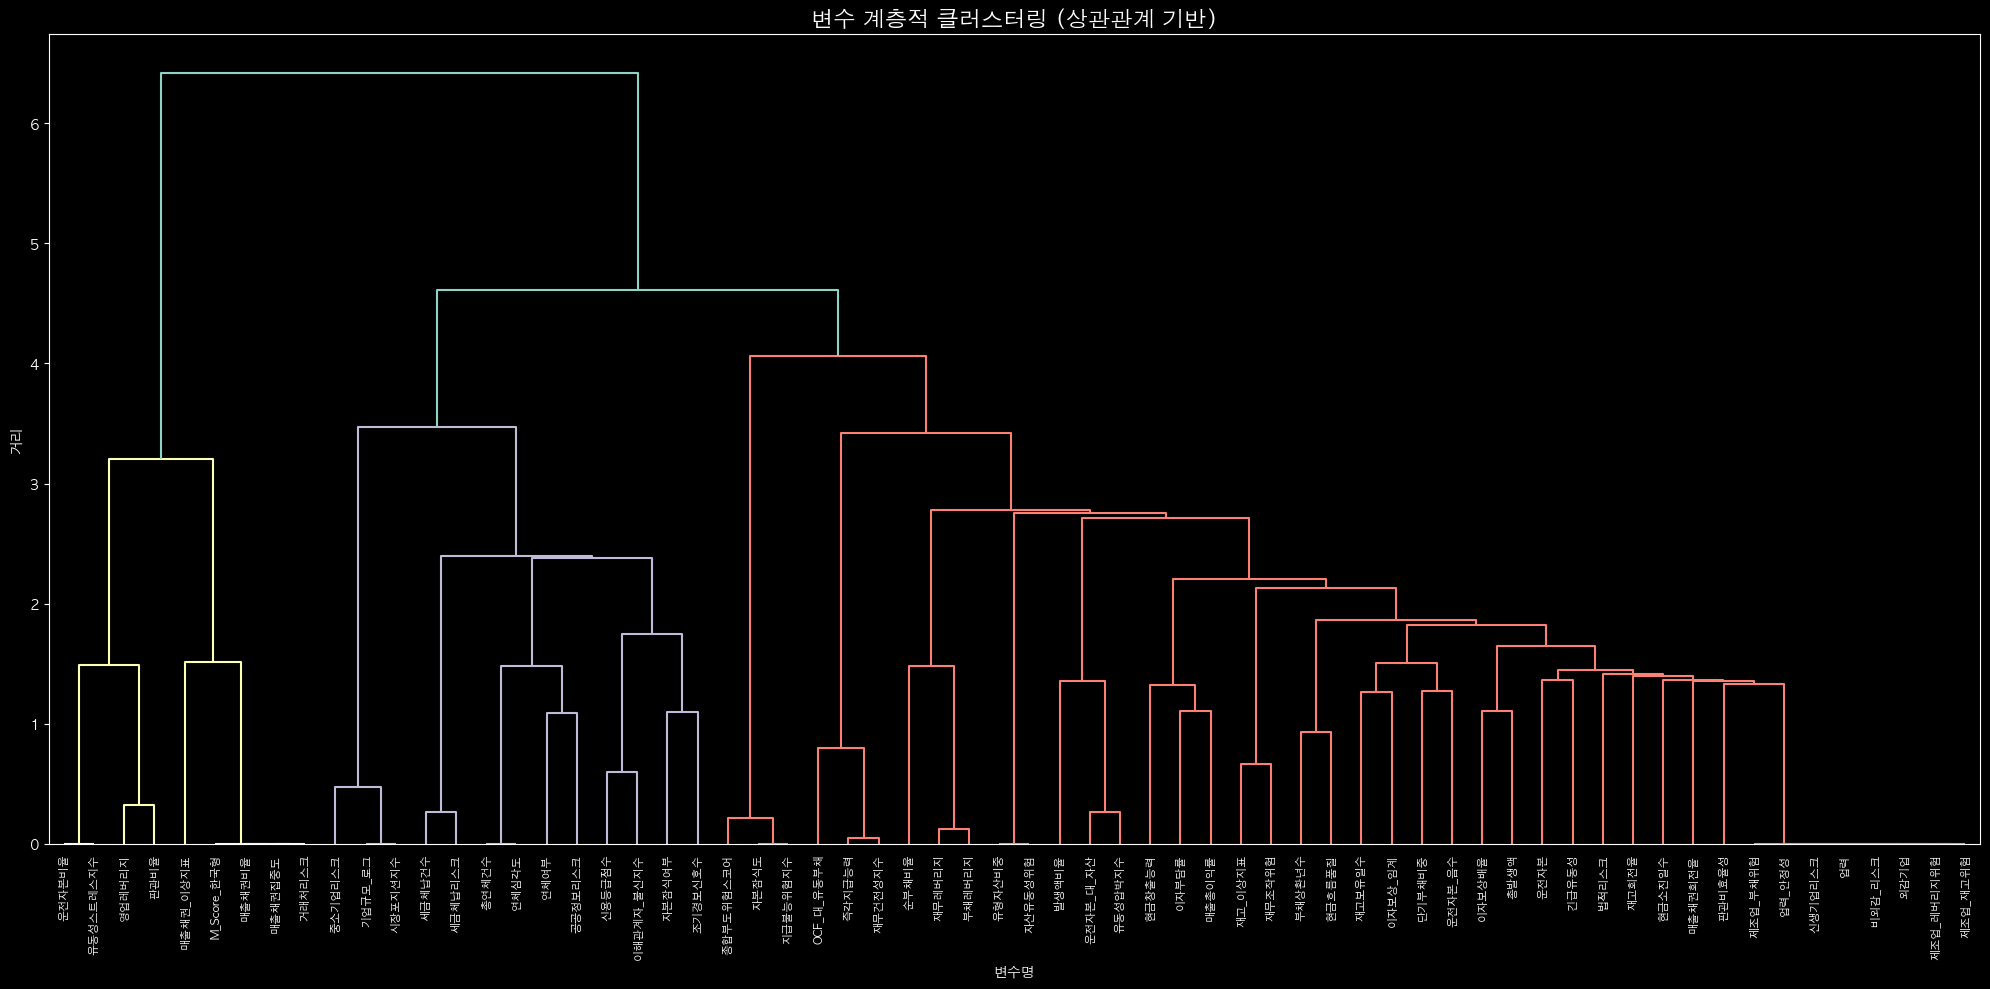


✅ 42개 클러스터로 변수 그룹화 완료

클러스터별 변수 수:
cluster
1     2
2     2
3     4
4     1
5     3
6     2
7     2
8     1
9     1
10    1
11    1
12    1
13    1
14    3
15    2
16    1
17    2
18    1
19    2
20    2
21    1
22    1
23    1
24    1
25    1
26    1
27    1
28    1
29    1
30    1
31    1
32    1
33    1
34    1
35    1
36    1
37    8
38    1
39    1
40    1
41    1
42    1
Name: count, dtype: int64


In [34]:
# 1. NaN 값 처리: 분산이 0인 변수 등으로 인해 발생한 NaN을 0(상관계수 없음)으로 대체
corr_matrix_filled = corr_matrix.fillna(0)

# 2. 거리 행렬 계산 (수정된 행렬 사용)
corr_dist = 1 - corr_matrix_filled.abs()

if corr_dist.isna().any().any() or np.isinf(corr_dist.values).any():
    print("⚠️ 거리 행렬에 여전히 NaN/Inf가 존재하여 보정합니다.")
    
    # 2. 보정 및 데이터프레임 형태 유지
    # np.nan_to_num은 결과를 numpy array로 반환하므로, 
    # 다시 DataFrame으로 감싸주어야 인덱스와 컬럼 정보가 유지됩니다.
    corr_dist_values = np.nan_to_num(corr_dist, nan=1.0, posinf=1.0, neginf=1.0)
    corr_dist = pd.DataFrame(corr_dist_values, index=corr_dist.index, columns=corr_dist.columns)

# 3. 계층적 클러스터링 수행
linkage_matrix = hierarchy.linkage(corr_dist, method='ward')


# 덴드로그램
plt.figure(figsize=(20, 10))
dendro = hierarchy.dendrogram(
    linkage_matrix,
    labels=corr_matrix.columns,
    leaf_rotation=90,
    leaf_font_size=8
)
plt.title('변수 계층적 클러스터링 (상관관계 기반)', fontsize=16)
plt.xlabel('변수명')
plt.ylabel('거리')
plt.tight_layout()
plt.show()

# 클러스터 생성 (거리 임계값 = 0.5)
clusters = hierarchy.fcluster(linkage_matrix, t=0.5, criterion='distance')
cluster_df = pd.DataFrame({
    'feature': corr_matrix.columns,
    'cluster': clusters
})

print(f"\n✅ {cluster_df['cluster'].nunique()}개 클러스터로 변수 그룹화 완료")
print("\n클러스터별 변수 수:")
print(cluster_df['cluster'].value_counts().sort_index())

## 3. VIF를 이용한 다중공선성 탐지

In [35]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df):
    """VIF 계산 함수"""
    vif_data = pd.DataFrame()
    vif_data["특성"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    return vif_data.sort_values('VIF', ascending=False)

# 샘플링하여 VIF 계산 (전체 특성은 시간이 오래 걸림)
sample_features = target_corr.head(50).index.tolist() if target_col in df.columns else numeric_features[:50]
df_sample = df_numeric[sample_features].sample(min(1000, len(df_numeric)), random_state=42)

print("VIF 계산 중... (상위 50개 특성)")
vif_results = calculate_vif(df_sample)

print("\n⚠️ VIF > 10인 특성 (다중공선성 의심):")
high_vif = vif_results[vif_results['VIF'] > 10]
print(high_vif.head(20))

# 시각화
fig = go.Figure()
fig.add_trace(go.Bar(
    y=vif_results.head(20)['특성'].values[::-1],
    x=vif_results.head(20)['VIF'].values[::-1],
    orientation='h',
    marker_color=['red' if x > 10 else 'lightblue' for x in vif_results.head(20)['VIF'].values[::-1]]
))

fig.add_vline(x=10, line_dash="dash", line_color="red", annotation_text="VIF=10")
fig.update_layout(
    title='VIF (Variance Inflation Factor) - 상위 20개',
    xaxis_title='VIF',
    yaxis_title='특성',
    height=600
)
fig.show()

VIF 계산 중... (상위 50개 특성)

⚠️ VIF > 10인 특성 (다중공선성 의심):
             특성           VIF
41      매출채권집중도           inf
28       운전자본비율           inf
40       거래처리스크           inf
39  M_Score_한국형           inf
35    종합부도위험스코어           inf
27    유동성스트레스지수           inf
34     지급불능위험지수           inf
7         총연체건수           inf
8         연체심각도           inf
42       매출채권비율           inf
33        자본잠식도  3.105931e+14
19        발생액비율  2.502000e+14
13      재고_이상지표  2.001600e+14
17      기업규모_로그  4.372427e+13
47      자산유동성위험  3.012441e+13
48       유형자산비중  1.471765e+13
16      시장포지션지수  1.183600e+13
32       단기부채비중  4.957182e+12
23       재무조작위험  2.230057e+12
1          연체여부  1.040813e+12


## 4. Information Value (IV) 계산

In [36]:
def calculate_iv(df, feature, target, bins=10):
    """Information Value 계산"""
    try:
        # 연속형 변수를 구간화
        df_temp = pd.DataFrame({
            'feature': df[feature],
            'target': target
        }).dropna()
        
        if len(df_temp) == 0:
            return 0
        
        # 분위수 기반 구간화
        df_temp['feature_bin'] = pd.qcut(df_temp['feature'], q=bins, duplicates='drop')
        
        # 각 구간별 Good/Bad 계산
        grouped = df_temp.groupby('feature_bin')['target'].agg([
            ('good', lambda x: (x == 0).sum()),
            ('bad', lambda x: (x == 1).sum())
        ])
        
        # 전체 Good/Bad
        total_good = (target == 0).sum()
        total_bad = (target == 1).sum()
        
        # WOE 및 IV 계산
        grouped['good_pct'] = grouped['good'] / total_good
        grouped['bad_pct'] = grouped['bad'] / total_bad
        
        # 0으로 나누기 방지
        grouped['good_pct'] = grouped['good_pct'].replace(0, 0.0001)
        grouped['bad_pct'] = grouped['bad_pct'].replace(0, 0.0001)
        
        grouped['woe'] = np.log(grouped['bad_pct'] / grouped['good_pct'])
        grouped['iv'] = (grouped['bad_pct'] - grouped['good_pct']) * grouped['woe']
        
        return grouped['iv'].sum()
    except:
        return 0

# 모든 특성의 IV 계산
if target_col in df.columns:
    print("Information Value 계산 중...")
    iv_results = []
    
    for feature in numeric_features:
        iv = calculate_iv(df, feature, df[target_col])
        iv_results.append((feature, iv))
    
    iv_df = pd.DataFrame(iv_results, columns=['특성', 'IV']).sort_values('IV', ascending=False)
    
    # IV 해석 기준
    # < 0.02: 예측력 없음
    # 0.02 ~ 0.1: 약한 예측력
    # 0.1 ~ 0.3: 중간 예측력
    # 0.3 ~ 0.5: 강한 예측력
    # > 0.5: 의심스러운 예측력 (과적합 위험)
    
    iv_df['예측력'] = pd.cut(iv_df['IV'], 
                          bins=[0, 0.02, 0.1, 0.3, 0.5, np.inf],
                          labels=['없음', '약함', '중간', '강함', '과적합위험'])
    
    print("\n📊 Information Value 상위 30개 특성:")
    print(iv_df.head(30))
    
    print("\n예측력 분포:")
    print(iv_df['예측력'].value_counts())
    
    # 시각화
    fig = go.Figure()
    colors = {'없음': 'lightgray', '약함': 'yellow', '중간': 'orange', '강함': 'green', '과적합위험': 'red'}
    
    top30 = iv_df.head(30)
    fig.add_trace(go.Bar(
        y=top30['특성'].values[::-1],
        x=top30['IV'].values[::-1],
        orientation='h',
        marker_color=[colors[x] for x in top30['예측력'].values[::-1]],
        text=top30['예측력'].values[::-1],
        textposition='outside'
    ))
    
    fig.add_vline(x=0.1, line_dash="dash", line_color="orange", annotation_text="중간")
    fig.add_vline(x=0.3, line_dash="dash", line_color="green", annotation_text="강함")
    
    fig.update_layout(
        title='Information Value (IV) - 상위 30개 특성',
        xaxis_title='IV',
        yaxis_title='특성',
        height=800
    )
    fig.show()

Information Value 계산 중...

📊 Information Value 상위 30개 특성:
             특성        IV    예측력
54   이해관계자_불신지수  2.205018  과적합위험
53       신용등급점수  1.666687  과적합위험
60      조기경보신호수  0.767655  과적합위험
59    종합부도위험스코어  0.321601     강함
15        순부채비율  0.222959     중간
17       부채레버리지  0.209857     중간
13        이자부담률  0.175438     중간
55      재무건전성지수  0.164611     중간
16       재무레버리지  0.162108     중간
57     지급불능위험지수  0.143710     중간
12       이자보상배율  0.142314     중간
20    매출채권_이상지표  0.140919     중간
7       유동성압박지수  0.124167     중간
14       부채상환년수  0.115629     중간
0        즉각지급능력  0.108194     중간
21        재고회전율  0.106857     중간
3        운전자본비율  0.104397     중간
56    유동성스트레스지수  0.100472     중간
30       판관비효율성  0.098376     약함
22       재고보유일수  0.092066     약함
8    OCF_대_유동부채  0.090449     약함
18      매출채권회전율  0.082383     약함
5         긴급유동성  0.081632     약함
31  M_Score_한국형  0.077112     약함
24         총발생액  0.070787     약함
33      매출채권집중도  0.068190     약함
34       거래처리스크  0.068190     약함
19       매출채권비율  0

## 5. 특성 선택 전략

In [37]:
def select_features(corr_matrix, iv_df, vif_results, corr_threshold=0.9, iv_threshold=0.02, vif_threshold=10):
    """다중 기준을 사용한 특성 선택"""
    
    selected_features = set()
    removed_features = set()
    
    # 1단계: IV 기준 필터링 (IV > threshold)
    good_iv_features = set(iv_df[iv_df['IV'] > iv_threshold]['특성'].tolist())
    print(f"1단계: IV > {iv_threshold} 특성: {len(good_iv_features)}개")
    
    # 2단계: 고상관 변수 쌍 중 하나 제거
    features_to_check = list(good_iv_features)
    corr_subset = corr_matrix.loc[features_to_check, features_to_check]
    
    for i in range(len(corr_subset.columns)):
        for j in range(i+1, len(corr_subset.columns)):
            if abs(corr_subset.iloc[i, j]) > corr_threshold:
                feat1 = corr_subset.columns[i]
                feat2 = corr_subset.columns[j]
                
                # IV가 낮은 특성 제거
                iv1 = iv_df[iv_df['특성'] == feat1]['IV'].values[0] if len(iv_df[iv_df['특성'] == feat1]) > 0 else 0
                iv2 = iv_df[iv_df['특성'] == feat2]['IV'].values[0] if len(iv_df[iv_df['특성'] == feat2]) > 0 else 0
                
                if iv1 < iv2:
                    removed_features.add(feat1)
                else:
                    removed_features.add(feat2)
    
    selected_features = good_iv_features - removed_features
    print(f"2단계: 고상관 제거 후: {len(selected_features)}개")
    print(f"  - 제거된 특성: {len(removed_features)}개")
    
    # 3단계: VIF 확인 (참고용)
    if vif_results is not None:
        high_vif_features = set(vif_results[vif_results['VIF'] > vif_threshold]['특성'].tolist())
        vif_warning = selected_features.intersection(high_vif_features)
        print(f"3단계: VIF > {vif_threshold} 경고 특성: {len(vif_warning)}개")
    
    return list(selected_features), list(removed_features)

# 특성 선택 실행
selected_features, removed_features = select_features(
    corr_matrix, iv_df, vif_results,
    corr_threshold=0.9,
    iv_threshold=0.02,
    vif_threshold=10
)

print(f"\n✅ 최종 선택된 특성: {len(selected_features)}개")
print(f"\n선택된 특성 예시 (상위 20개):")
selected_iv = iv_df[iv_df['특성'].isin(selected_features)].head(20)
print(selected_iv)

1단계: IV > 0.02 특성: 44개
2단계: 고상관 제거 후: 35개
  - 제거된 특성: 9개
3단계: VIF > 10 경고 특성: 18개

✅ 최종 선택된 특성: 35개

선택된 특성 예시 (상위 20개):
             특성        IV    예측력
54   이해관계자_불신지수  2.205018  과적합위험
53       신용등급점수  1.666687  과적합위험
60      조기경보신호수  0.767655  과적합위험
59    종합부도위험스코어  0.321601     강함
15        순부채비율  0.222959     중간
17       부채레버리지  0.209857     중간
13        이자부담률  0.175438     중간
55      재무건전성지수  0.164611     중간
12       이자보상배율  0.142314     중간
20    매출채권_이상지표  0.140919     중간
7       유동성압박지수  0.124167     중간
14       부채상환년수  0.115629     중간
21        재고회전율  0.106857     중간
3        운전자본비율  0.104397     중간
30       판관비효율성  0.098376     약함
22       재고보유일수  0.092066     약함
8    OCF_대_유동부채  0.090449     약함
18      매출채권회전율  0.082383     약함
5         긴급유동성  0.081632     약함
31  M_Score_한국형  0.077112     약함


## 6. 상관관계 네트워크 시각화

In [38]:
# 상위 30개 특성으로 네트워크 그래프 생성
top_features = iv_df.head(30)['특성'].tolist()
corr_top = corr_matrix.loc[top_features, top_features]

# NetworkX 그래프 생성
G = nx.Graph()

# 노드 추가
for feature in top_features:
    G.add_node(feature)

# 엣지 추가 (|r| > 0.5인 경우만)
for i in range(len(corr_top.columns)):
    for j in range(i+1, len(corr_top.columns)):
        corr_val = corr_top.iloc[i, j]
        if abs(corr_val) > 0.5:
            G.add_edge(corr_top.columns[i], corr_top.columns[j], weight=abs(corr_val))

# 레이아웃
pos = nx.spring_layout(G, k=2, iterations=50)

# Plotly로 시각화
edge_trace = []
for edge in G.edges(data=True):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace.append(go.Scatter(
        x=[x0, x1, None],
        y=[y0, y1, None],
        mode='lines',
        line=dict(width=edge[2]['weight']*3, color='lightgray'),
        hoverinfo='none',
        showlegend=False
    ))

node_x = [pos[node][0] for node in G.nodes()]
node_y = [pos[node][1] for node in G.nodes()]
node_text = list(G.nodes())

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    text=node_text,
    textposition="top center",
    hoverinfo='text',
    marker=dict(
        size=20,
        color='lightblue',
        line=dict(width=2, color='darkblue')
    )
)

fig = go.Figure(data=edge_trace + [node_trace])
fig.update_layout(
    title='특성 상관관계 네트워크 (|r| > 0.5)',
    showlegend=False,
    hovermode='closest',
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    height=700
)
fig.show()

## 7. ML 파이프라인 시각화

In [39]:
import plotly.graph_objects as go

# 1. 실제 분석된 데이터 수치 정의 (노트북 01~03 분석 결과)
# - NB1 원본 로딩: 159개
# - NB2~3 도메인 특성 선별: 64개 (95개 제거/변환)
# - NB3 IV 필터링: 44개 (20개 제거)
# - NB3 상관관계/VIF 제거: 35개 (9개 제거)
# - 최종 모델: 35개

counts = {
    'raw': 159,
    'domain': 64,
    'iv': 44,
    'corr': 35,
    'final': 35
}

# 2. Sankey 노드 및 링크 설정
labels = [
    f"원본 데이터<br>({counts['raw']}개)",           # Node 0
    f"도메인 특성 선별<br>({counts['domain']}개)",   # Node 1
    f"IV 필터링<br>({counts['iv']}개)",              # Node 2
    f"다중공선성 제거<br>({counts['corr']}개)",      # Node 3
    f"최종 모델<br>({counts['final']}개)",           # Node 4
    "제거된 변수<br>(Low Quality)"                   # Node 5 (쓰레기통)
]

# 색상 설정 (프로세스는 파란색 계열, 제거는 회색)
colors = ["#1f77b4", "#4ba3c3", "#85c4d6", "#bce0ea", "#2ca02c", "#d3d3d3"]

source = []
target = []
value = []
link_colors = []

# 함수: 흐름 추가 (Main Flow & Dropped Flow)
def add_flow(src_idx, tgt_idx, val, is_drop=False):
    source.append(src_idx)
    target.append(tgt_idx)
    value.append(val)
    # 메인 흐름은 투명한 파랑, 제거 흐름은 투명한 회색
    link_colors.append("rgba(31, 119, 180, 0.4)" if not is_drop else "rgba(200, 200, 200, 0.3)")

# 단계별 흐름 정의
# Step 1: 원본 -> 도메인 특성
add_flow(0, 1, counts['domain'])
add_flow(0, 5, counts['raw'] - counts['domain'], is_drop=True) # 95개 제거

# Step 2: 도메인 -> IV 필터링
add_flow(1, 2, counts['iv'])
add_flow(1, 5, counts['domain'] - counts['iv'], is_drop=True) # 20개 제거

# Step 3: IV -> 상관관계 제거
add_flow(2, 3, counts['corr'])
add_flow(2, 5, counts['iv'] - counts['corr'], is_drop=True) # 9개 제거

# Step 4: 상관관계 -> 최종 모델
add_flow(3, 4, counts['final'])
# (여기서는 제거된 게 없음)

# 3. 시각화 생성
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=20,
        thickness=30,
        line=dict(color="black", width=0.5),
        label=labels,
        color=colors,
        hovertemplate='%{label}<br>수량: %{value}개<extra></extra>'
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors,
        hovertemplate='%{source.label} → %{target.label}<br>이동: %{value}개<extra></extra>'
    )
)])

fig.update_layout(
    title_text="<b>End-to-End 부도예측 변수 최적화 파이프라인</b><br><span style='font-size:12px; color:gray'>Raw Data(159개)에서 Final Feature(35개)까지의 정제 과정</span>",
    font_size=13,
    height=600,
    margin=dict(l=50, r=50, t=80, b=50)
)

fig.show()

print(f"\n📊 파이프라인 요약:")
print(f"  → 원본 변수 : 159개")
print(f"  → 도메인 기반 전처리 후 : {n_original}개({(n_original/159*100):.1f}%)")
print(f"  → IV 필터링 후: {n_iv_filtered}개 ({(n_iv_filtered/159*100):.1f}%)")
print(f"  → 상관관계 제거 후: {n_corr_removed}개 ({(n_corr_removed/159*100):.1f}%)")
print(f"  → 최종 특성: {n_final}개 ({(n_final/159*100):.1f}%)")


📊 파이프라인 요약:
  → 원본 변수 : 159개
  → 도메인 기반 전처리 후 : 64개(40.3%)
  → IV 필터링 후: 44개 (27.7%)
  → 상관관계 제거 후: 35개 (22.0%)
  → 최종 특성: 35개 (22.0%)


## 8. 선택된 특성 저장

In [40]:
# 선택된 특성으로 최종 데이터셋 생성
final_dataset = df[[target_col] + selected_features].copy()

# 저장
output_path = '../data/processed/selected_features.csv'
final_dataset.to_csv(output_path, index=False, encoding='utf-8-sig')
print(f"✅ 선택된 특성 데이터셋 저장: {output_path}")

# 특성 선택 메타데이터 저장
selection_metadata = pd.DataFrame({
    'feature': selected_features,
    'iv': [iv_df[iv_df['특성'] == f]['IV'].values[0] if len(iv_df[iv_df['특성'] == f]) > 0 else 0 for f in selected_features],
    'selected': True
})

metadata_path = '../data/processed/feature_selection_metadata.csv'
selection_metadata.to_csv(metadata_path, index=False, encoding='utf-8-sig')
print(f"✅ 특성 선택 메타데이터 저장: {metadata_path}")

print(f"\n📊 최종 데이터셋 shape: {final_dataset.shape}")
print(f"   - 타겟 변수: 1개")
print(f"   - 선택된 특성: {len(selected_features)}개")

✅ 선택된 특성 데이터셋 저장: ../data/processed/selected_features.csv
✅ 특성 선택 메타데이터 저장: ../data/processed/feature_selection_metadata.csv

📊 최종 데이터셋 shape: (50105, 36)
   - 타겟 변수: 1개
   - 선택된 특성: 35개


## 9. 핵심 인사이트

In [41]:
print("\n" + "="*80)
print("📌 상관관계 및 리스크 패턴 분석 - 핵심 인사이트")
print("="*80)

insights = [
    f"1. 고상관 변수 쌍: {len(high_corr_pairs)}개 발견 (|r| > 0.8)",
    f"2. IV 기반 예측력: 강함 이상 {len(iv_df[iv_df['IV'] > 0.3])}개 특성",
    f"3. 다중공선성: VIF > 10인 특성 {len(high_vif)}개",
    f"4. 최종 선택: {len(selected_features)}개 특성 (원본의 {len(selected_features)/n_original*100:.1f}%)",
    "5. 계층적 클러스터링으로 유사 특성 그룹화 완료",
    "6. 네트워크 분석으로 특성 간 관계 시각화"
]

for insight in insights:
    print(insight)

print("\n" + "="*80)
print("🎯 다음 단계: 불균형 분류 모델링")
print("="*80)
print("1. 선택된 특성으로 SMOTE + Tomek Links 적용")
print("2. LightGBM, XGBoost, CatBoost 앙상블")
print("3. Focal Loss 및 비용 민감 학습")
print("4. PR-AUC 중심 평가")


📌 상관관계 및 리스크 패턴 분석 - 핵심 인사이트
1. 고상관 변수 쌍: 19개 발견 (|r| > 0.8)
2. IV 기반 예측력: 강함 이상 4개 특성
3. 다중공선성: VIF > 10인 특성 34개
4. 최종 선택: 35개 특성 (원본의 54.7%)
5. 계층적 클러스터링으로 유사 특성 그룹화 완료
6. 네트워크 분석으로 특성 간 관계 시각화

🎯 다음 단계: 불균형 분류 모델링
1. 선택된 특성으로 SMOTE + Tomek Links 적용
2. LightGBM, XGBoost, CatBoost 앙상블
3. Focal Loss 및 비용 민감 학습
4. PR-AUC 중심 평가


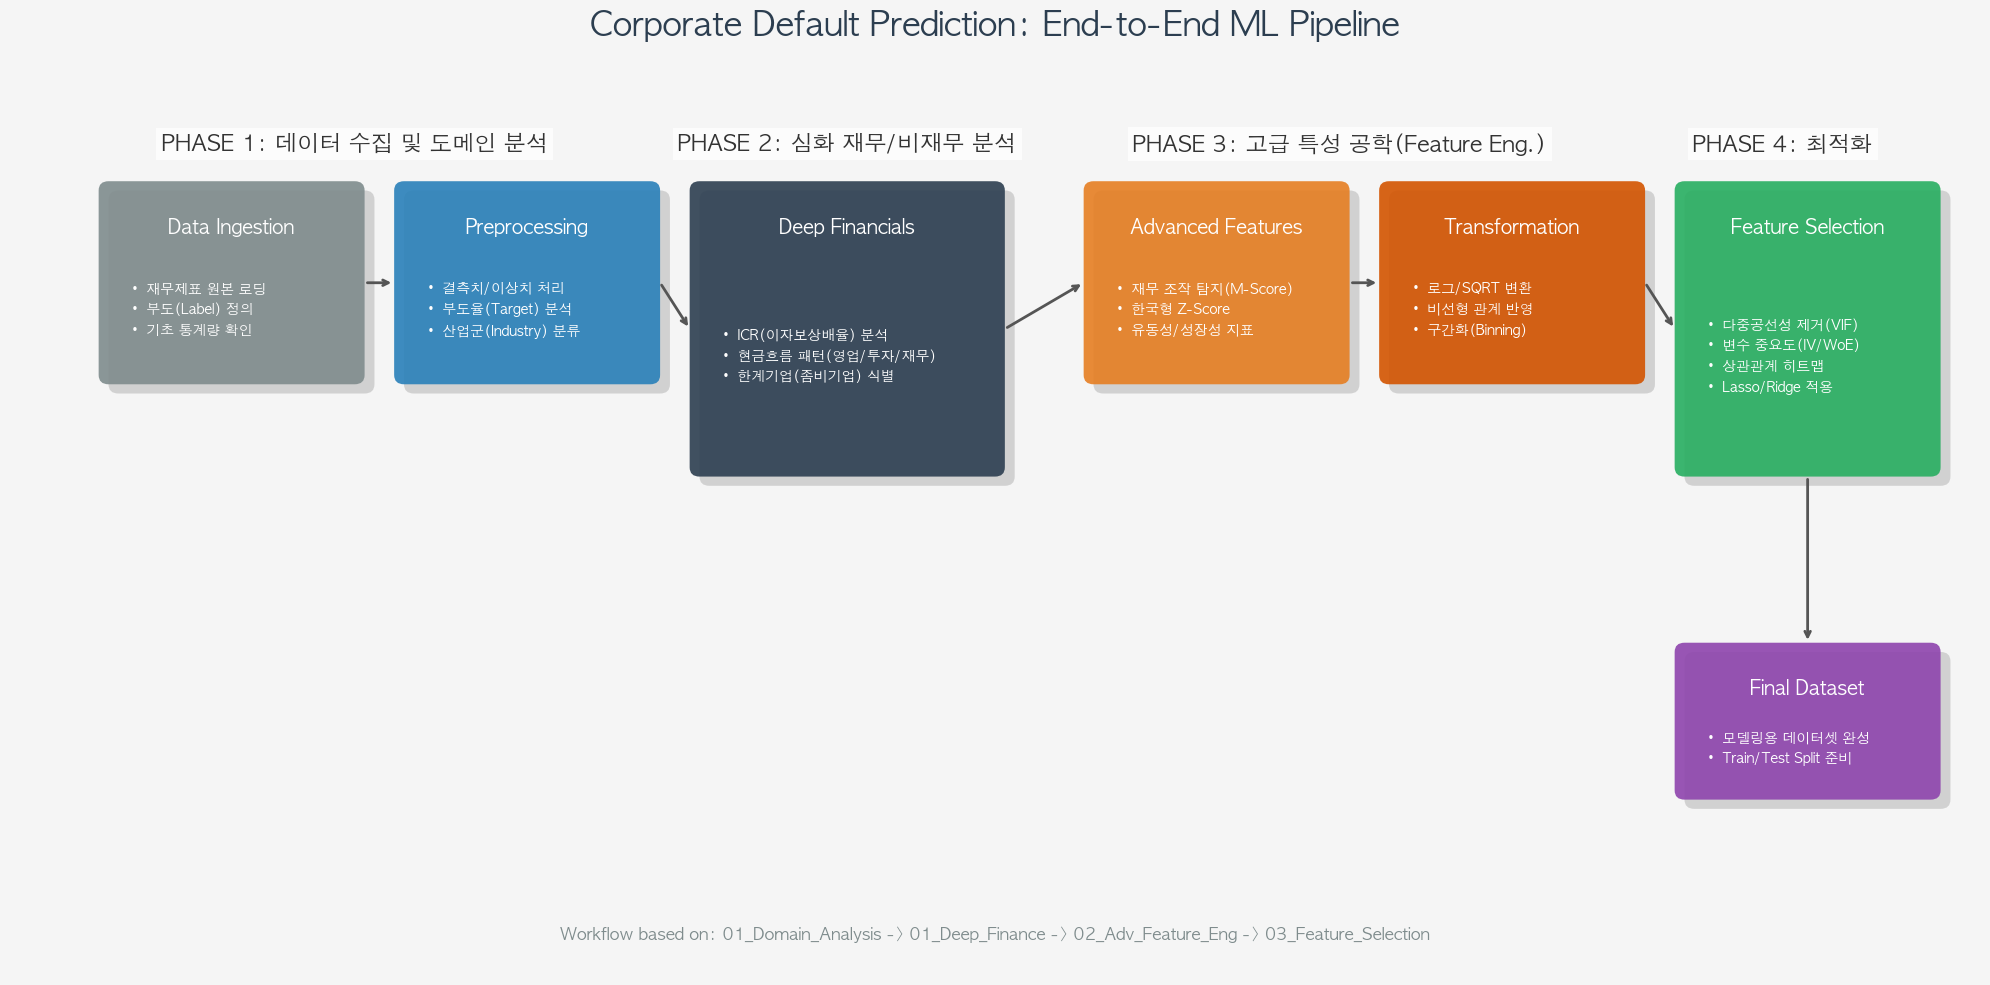

In [42]:
def draw_pipeline_flowchart():
    """
    금융 데이터 ML 파이프라인(End-to-End)을 시각화하는 함수
    """
    
    # 1. 폰트 설정 (한글 깨짐 방지)
    # 시스템에 따라 적절한 한글 폰트를 자동으로 선택합니다.
    if sys.platform == 'darwin': 
        font_name = 'AppleGothic' # Mac
    elif sys.platform == 'win32': 
        font_name = 'Malgun Gothic' # Windows
    else: 
        font_name = 'NanumGothic' # Linux/Colab (설치 필요 시)
    
    plt.rcParams['font.family'] = font_name
    plt.rcParams['axes.unicode_minus'] = False

    # 2. 캔버스 설정
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_xlim(0, 20)
    ax.set_ylim(0, 10)
    ax.axis('off') # 축 숨기기
    
    # 배경색 설정 (전문적인 느낌의 옅은 회색)
    fig.patch.set_facecolor('#f5f5f5')
    ax.set_facecolor('#f5f5f5')

    # ==========================================
    # 3. 유틸리티 함수 정의 (도형 및 텍스트 그리기)
    # ==========================================
    def draw_box(x, y, w, h, color, title, details, title_color='white'):
        # 그림자 효과
        shadow = patches.FancyBboxPatch((x+0.1, y-0.1), w, h, boxstyle="round,pad=0.1", 
                                        ec="none", fc='gray', alpha=0.3)
        ax.add_patch(shadow)
        
        # 메인 박스
        box = patches.FancyBboxPatch((x, y), w, h, boxstyle="round,pad=0.1", 
                                     ec="none", fc=color, alpha=0.9)
        ax.add_patch(box)
        
        # 제목
        ax.text(x + w/2, y + h - 0.4, title, ha='center', va='center', 
                fontsize=14, fontweight='bold', color=title_color)
        
        # 세부 내용 (글머리 기호 포함)
        detail_text = "\n".join([f"• {d}" for d in details])
        ax.text(x + 0.2, y + h/2 - 0.3, detail_text, ha='left', va='center', 
                fontsize=10, color='white' if title_color=='white' else 'black', linespacing=1.6)

    def draw_arrow(x_start, y_start, x_end, y_end):
        ax.annotate("", xy=(x_end, y_end), xytext=(x_start, y_start),
                    arrowprops=dict(arrowstyle="->", lw=2, color='#555555', 
                                    connectionstyle="arc3,rad=0"))

    def draw_phase_label(x, y, text):
        ax.text(x, y, text, ha='center', va='center', fontsize=16, 
                fontweight='bold', color='#333333', bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    # ==========================================
    # 4. 파이프라인 단계 정의 (노트북 분석 결과 반영)
    # ==========================================
    
    # [Phase 1] 데이터 수집 및 기초 분석 (Notebook 01)
    draw_phase_label(3.5, 9, "PHASE 1: 데이터 수집 및 도메인 분석")
    
    # Node 1-1: 원천 데이터
    draw_box(1, 6.5, 2.5, 2, '#7f8c8d', "Data Ingestion", 
             ["재무제표 원본 로딩", "부도(Label) 정의", "기초 통계량 확인"])
    
    # Node 1-2: 전처리 & EDA
    draw_box(4, 6.5, 2.5, 2, '#2980b9', "Preprocessing", 
             ["결측치/이상치 처리", "부도율(Target) 분석", "산업군(Industry) 분류"])

    # [Phase 2] 심화 재무 분석 (Notebook 01_심화)
    draw_phase_label(8.5, 9, "PHASE 2: 심화 재무/비재무 분석")
    
    # Node 2-1: 재무 비율 심화
    draw_box(7, 5.5, 3, 3, '#2c3e50', "Deep Financials", 
             ["ICR(이자보상배율) 분석", "현금흐름 패턴(영업/투자/재무)", "한계기업(좀비기업) 식별"])
    
    # [Phase 3] 고급 특성 공학 (Notebook 02)
    draw_phase_label(13.5, 9, "PHASE 3: 고급 특성 공학(Feature Eng.)")

    # Node 3-1: 파생 변수 생성
    draw_box(11, 6.5, 2.5, 2, '#e67e22', "Advanced Features", 
             ["재무 조작 탐지(M-Score)", "한국형 Z-Score", "유동성/성장성 지표"])
    
    # Node 3-2: 변수 변환
    draw_box(14, 6.5, 2.5, 2, '#d35400', "Transformation", 
             ["로그/SQRT 변환", "비선형 관계 반영", "구간화(Binning)"])

    # [Phase 4] 변수 최적화 및 최종셋 (Notebook 03)
    draw_phase_label(18, 9, "PHASE 4: 최적화")

    # Node 4-1: 변수 선택
    draw_box(17, 5.5, 2.5, 3, '#27ae60', "Feature Selection", 
             ["다중공선성 제거(VIF)", "변수 중요도(IV/WoE)", "상관관계 히트맵", "Lasso/Ridge 적용"])

    # [Final Output]
    draw_box(17, 2, 2.5, 1.5, '#8e44ad', "Final Dataset", 
             ["모델링용 데이터셋 완성", "Train/Test Split 준비"], title_color='white')


    # ==========================================
    # 5. 흐름 연결 (Arrows)
    # ==========================================
    
    # Phase 1 내부 연결
    draw_arrow(3.6, 7.5, 3.9, 7.5)
    
    # Phase 1 -> Phase 2
    draw_arrow(6.6, 7.5, 6.9, 7.0) # Preprocessing -> Deep Financials
    
    # Phase 2 -> Phase 3
    draw_arrow(10.1, 7.0, 10.9, 7.5) # Deep Financials -> Advanced Features
    
    # Phase 3 내부 연결
    draw_arrow(13.6, 7.5, 13.9, 7.5)
    
    # Phase 3 -> Phase 4
    draw_arrow(16.6, 7.5, 16.9, 7.0)
    
    # Phase 4 -> Final Output
    draw_arrow(18.25, 5.4, 18.25, 3.6)

    # ==========================================
    # 6. 추가 장식 (타이틀 및 범례)
    # ==========================================
    plt.suptitle("Corporate Default Prediction: End-to-End ML Pipeline", 
                 fontsize=24, fontweight='bold', y=0.98, color='#2c3e50')
    
    # 하단 설명
    plt.figtext(0.5, 0.05, 
                "Workflow based on: 01_Domain_Analysis -> 01_Deep_Finance -> 02_Adv_Feature_Eng -> 03_Feature_Selection", 
                ha="center", fontsize=12, color='#7f8c8d')

    # 7. 출력 및 저장
    plt.tight_layout()
    plt.show()
    
    # 이미지 저장 코드가 필요하면 아래 주석 해제
    # fig.savefig('ml_pipeline_flowchart.png', dpi=300, bbox_inches='tight')

draw_pipeline_flowchart()